# Visual Inspection of Motorcycle Connecting comps
Author: Matteo Periani<br>
student-id: 0001039848<br>
date: 02/2023


In this project some known fuction as *2 scan* algorithm, *Otsu* and many other are implemented by myself. This will slow down the computation, but it helped me to better understand the theoretical part of the course.

In [403]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

As first thing, let's import the image and show it

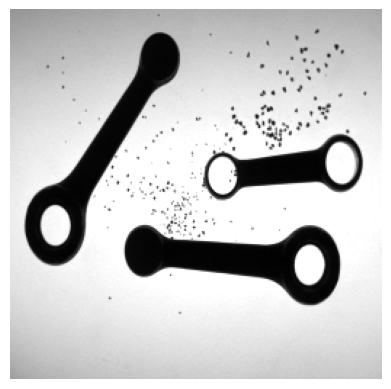

In [404]:
img_path = "./images/TESI92.BMP"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

### Image Binzarization using Otsu
**Otsu's method** is a alorithm to find the best threshold to binirize an imaghe. It iterate over all the possible values of threshold and measure the spread of background and foreground pixels. In this implementation instead use classic within-group variance, we use the **inter-group** varaince, to speed up the computation (no need to compute the classes variance).

Indeed, it can be proved that
$$ \sigma^2(t) = \sigma^2_W(t) + \sigma^2_B(t) $$
where $\sigma^2_W$ is *within-group* variance and is the *between-group*. It ealsy to see that if in the the best threshold minize $\sigma^2_W$, $\sigma^2_B$ is maximized. So, to speed up the computation, I used $\sigma^2_B$ because it not require to compute variances but only the means. 

The condition inside the main loop, is been added because in the case any pixel belog to a certain division class, we end up to dividing by 0. In this case, because this threshold value does not represet a good one, I decide to assign a negative value (variance cannot be negative), to be sure that it will be not taken into account.

In [405]:
def otsu(img): 
    h = np.zeros((256,))
    for l in range(256):
        h[l] = np.sum(img == l)
        
    p = h/np.sum(h)
    
    # BETWEEN-GROUP VARIANCE list
    bgv = []
    
    for T in range(256):
        if np.sum(h[:T+1]) > 0 and np.sum(h[T+1:]) > 0:   
            mu1, mu2 = 0, 0
            q1 = 0
            for l in range(256):
                if l <= T:
                    mu1 += l * p[l] / np.sum(h[:T+1])
                    q1 += p[l]
                else:
                    mu2 += l * p[l] / np.sum(h[T+1:])

            bgv.append(q1 * (1 - q1) * (mu1 - mu2) ** 2)
        else:
            bgv.append(-1)
    
    return np.argmax(bgv)

During binarization, a grayscale image is converted to B/W, reducing the 256 shades of gray to 2. In order to, we need to find a threshold **T**, in this case through Otsu and after assign new value to each pixen following the condition:

\begin{equation*}
    O(i,j) =
    \begin{cases}
        255 & \text{if } I(i,j) \leq T\\
        0 & otherwise
    \end{cases}
\end{equation*}

T: 121


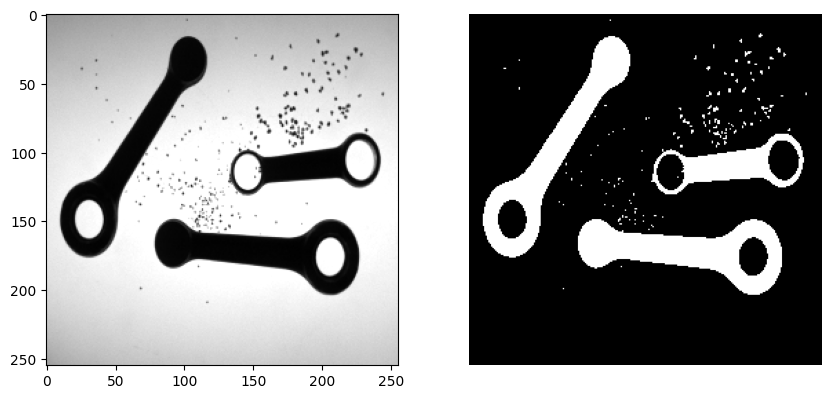

In [406]:
T = otsu(img)
print(f"T: {T}")
binarized_img = ((img <= T) * 255).astype('uint8')

f, plts = plt.subplots(1, 2, figsize=(10,10)) 
plts[0].imshow(img, cmap="gray")
plts[1].imshow(binarized_img, cmap="gray")
plt.axis('off')
plt.show()

### Remove noise
Now, if the original image contains impurities, such as dust and dirt, they will be present also after binarization step and we don't want it. So, to remove it we firstly apply a median filtering, which removes the smallest impurities, and then we removed the others by using some morphological operator.

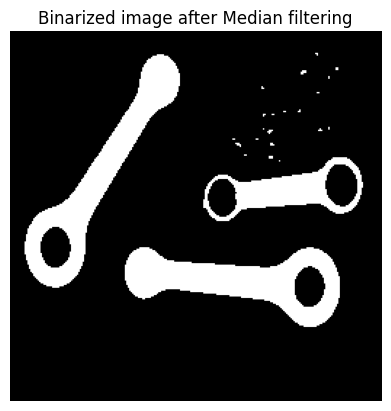

In [407]:
img_bin_blur = cv2.medianBlur(binarized_img, 3)

plt.imshow(img_bin_blur, cmap='gray')
plt.title('Binarized image after Median filtering')
plt.axis('off')
plt.show()

To affine noise elimination, without alterate too much image structure, we morphology operator such us Opening. Indeeed, using Opening (an erosion followed by dilatation) we can remove the most of white noise dust present in the binarized image. With this process, the first Dilatation is used to keep thin border safe from Erosion step. 

After Opening it may happens that object's structure can be compromised (e.g., on image TESI98 if we remove last two dilatation and erosion a rod have discontinuity). So, I decide to add this two step to reconstruct original image. 

The final image is obtained taking the *AND product* between the eroded image and the original one firstly and after another 2 step of median filtering are applied to remove residual noise.

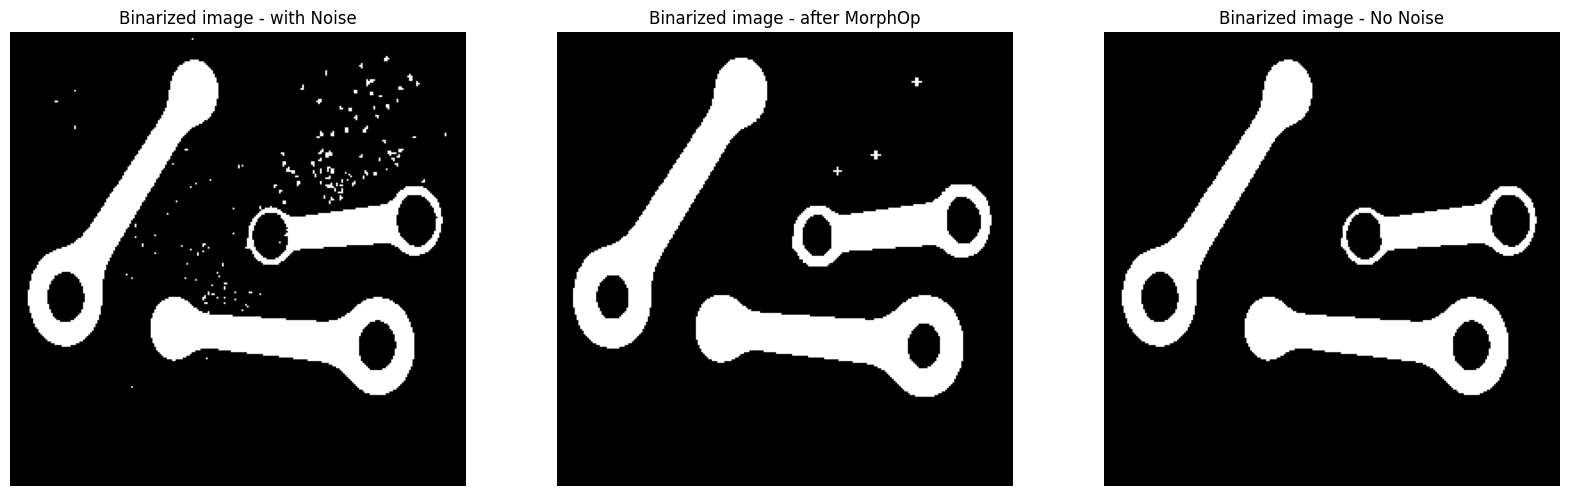

In [408]:
# Kernels for Morphological Operators
square_k = np.ones((3, 3), dtype=np.uint8)
cross_k =  np.array([[0, 0, 1, 0, 0],
                     [0, 0, 1, 0, 0],
                     [1, 1, 1, 1, 1],
                     [0, 0, 1, 0, 0],
                     [0, 0, 1, 0, 0]], dtype = np.uint8)

dilation1 = cv2.dilate(img_bin_blur, square_k, iterations = 1)
opening = cv2.morphologyEx(dilation1, cv2.MORPH_OPEN, cross_k)
dilation2 = cv2.dilate(opening, square_k, iterations = 2)
erosion = cv2.erode(dilation2, square_k, iterations = 2)

img_bin_denoised = cv2.bitwise_and(binarized_img, erosion)
img_bin_denoised = cv2.medianBlur(cv2.medianBlur(img_bin_denoised, 3), 3)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(binarized_img, cmap='gray')
plt.title('Binarized image - with Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Binarized image - after MorphOp')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image - No Noise')
plt.axis('off')
plt.show()

### Separate touching components
In this task we want separate the touching components, otherwise we cannot consider them independently during labeling phase. To do so, we have to search corners (that creates when two objects are touching) and draw separation lines between the objects.

As first things, remove holes to prevent internal ersosion.

(-0.5, 255.5, 254.5, -0.5)

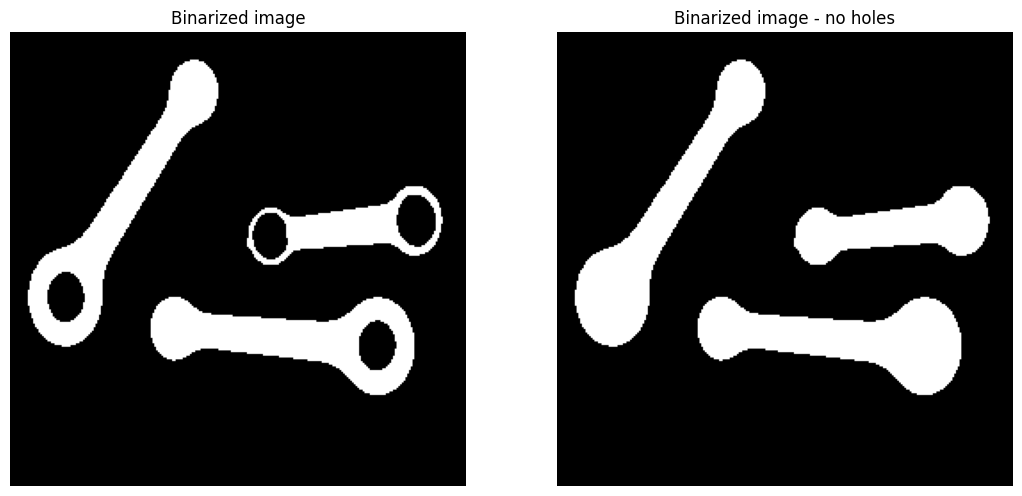

In [409]:
white_holes = img_bin_denoised.copy()
# Flood-filling
h, w = img_bin_denoised.shape[:2]
mask_filling = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(white_holes, mask_filling, (0,0), 255)
white_holes = cv2.bitwise_not(white_holes)
img_no_holes = img_bin_denoised + white_holes

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_no_holes, cmap='gray')
plt.title('Binarized image - no holes')
plt.axis('off')

Then we apply the Harris' corner detector to find corners...

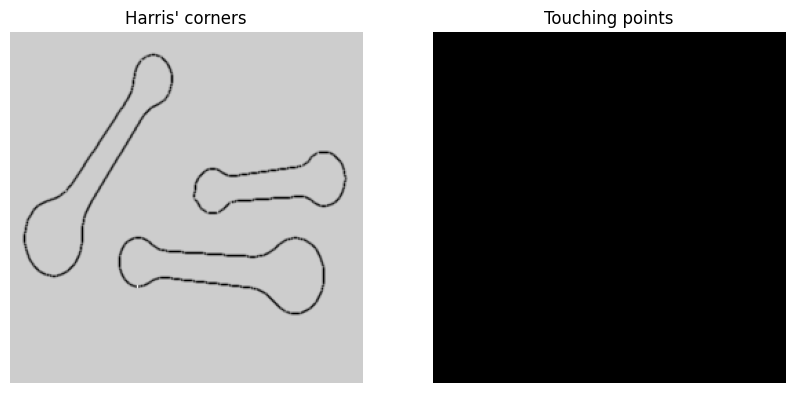

In [410]:
harris = cv2.cornerHarris(img_no_holes,2,5,0.04)

# Find Centroids of touching corners
_, _, _, centroids = cv2.connectedComponentsWithStats(((harris>1)*255).astype('uint8'), 4, cv2.CV_32S)

# Show corners in the image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(harris, cmap='gray')
plt.title("Harris' corners")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(((harris>1)*255).astype('uint8'), cmap='gray')
plt.title("Touching points")
plt.axis('off')
plt.show()

At this point we have to deal with clusters of corners. Indeed, Harris' corner detector find multiple corners in a small area surrounding a corner. So, let's remove close points to obtain just one per cluster.

In [411]:
# start form index 1 to not take into account the all image barycenter
centroids = [tuple(c) for c in centroids[1:]]
good_centroids = centroids

print(f"All centroids: {centroids}")

i = 1    
for c1 in centroids:
    for c2 in centroids[i::1]:
        if(dist.euclidean(c1, c2) < 10):
            good_centroids.remove(c2)
    i+=1
    
print(f"Good centroids: {good_centroids}")

All centroids: []
Good centroids: []


Now, to separate the objects we have to find the pairs of points that are used in the next step to draw the line. To do this, we need to find the closet touple of points cordinates and store them together. Beacuse of that, we need at lest two centorids to perform this operation.

In [412]:
lines_extremes = []
n_centroids = len(good_centroids)

if n_centroids >= 2:
    # Find all the Conjunctions between pairs of near Centroids
    for i in range(n_centroids):
        min_pair_dist = 1000
        for j in range(n_centroids):
            if i != j:
                d = dist.euclidean(good_centroids[i], good_centroids[j])
                if d < min_pair_dist: 
                    min_pair_dist = d
                    best_i = i
                    best_j = j
        if (good_centroids[best_i], good_centroids[best_j]) not in lines_extremes:
            lines_extremes.append((good_centroids[best_i], good_centroids[best_j]))
    
print(lines_extremes)

[]


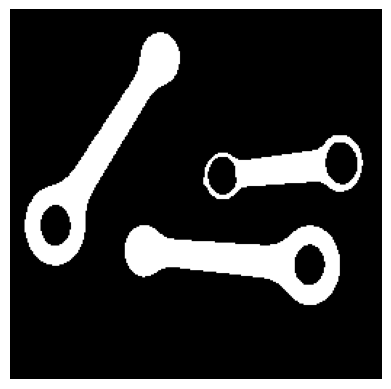

In [413]:
lines_extremes = [(round(pt[0]), round(pt[1])) for e in lines_extremes for pt in e]

im_bin_sep = np.copy(img_bin_denoised)

# Draw separation lines
for i in range(0, len(lines_extremes), 2):
    im_bin_sep = cv2.line(img_no_holes, lines_extremes[i], lines_extremes[i+1], color=[0,0,0], thickness=1)
    
plt.imshow(im_bin_sep, cmap='gray')
plt.axis('off')
plt.show()

### Compute connected components
To find individual components present in the image, I used a variation of the *2 scan algorithm*, which consist in only 1 scan where class equality are treated immediately. This does not effect efficiency of the original method, but it's only speed up it becasue image is scanned just once. 

In [414]:
def solve_class_equality(img, l_p, l_q):
    img[img == l_q] = l_p
    return img

def _2_scan_algorithm(img):
    label = 0
    labeled = np.zeros(img.shape, dtype='uint8')
    
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if img[i, j] == 255:
                l_p = img[i-1, j]
                l_q = img[i, j-1]
                
                # if the left and top pixel have different lables -> merge class
                if l_p == 255 and l_q == 255 and labeled[i, j-1] != labeled[i-1, j]:
                    labeled[i, j] = labeled[i, j-1] # choose above label
                    labeled = solve_class_equality(labeled, labeled[i, j-1], labeled[i-1, j])
                
                # if left pixel is labeled -> assign this label
                elif l_q == 255:
                    labeled[i, j] = labeled[i, j-1]
                 
                # if above is labeled -> assign this label   
                elif l_p == 255:
                    labeled[i, j] = labeled[i-1, j]
                
                # assign new label
                else:
                    label += 1
                    labeled[i, j] = label

    return labeled

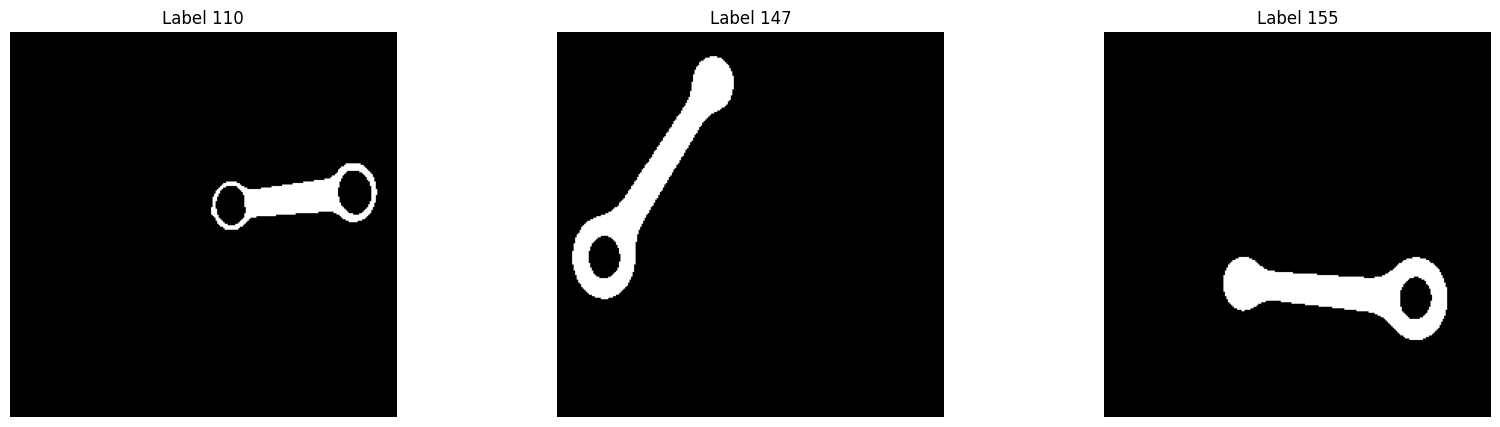

In [415]:
labeled_img = _2_scan_algorithm(im_bin_sep)

# Store the labels (excluding the BG)
labels = np.unique(labeled_img)[1:]

# Show the connected components
plt.figure(figsize=(20,5))
for idx, l in enumerate(labels):
    plt.subplot(1,len(labels), idx+1)
    plt.imshow((labeled_img == l)*255, cmap='gray')
    plt.title(f'Label {l}')
    plt.axis('off')
plt.show()

As you can see, some errors could be present (due noise in the binarization process), so to remove it, I decide to keep only those connected regions that have an area graten tha a chosen treshold.

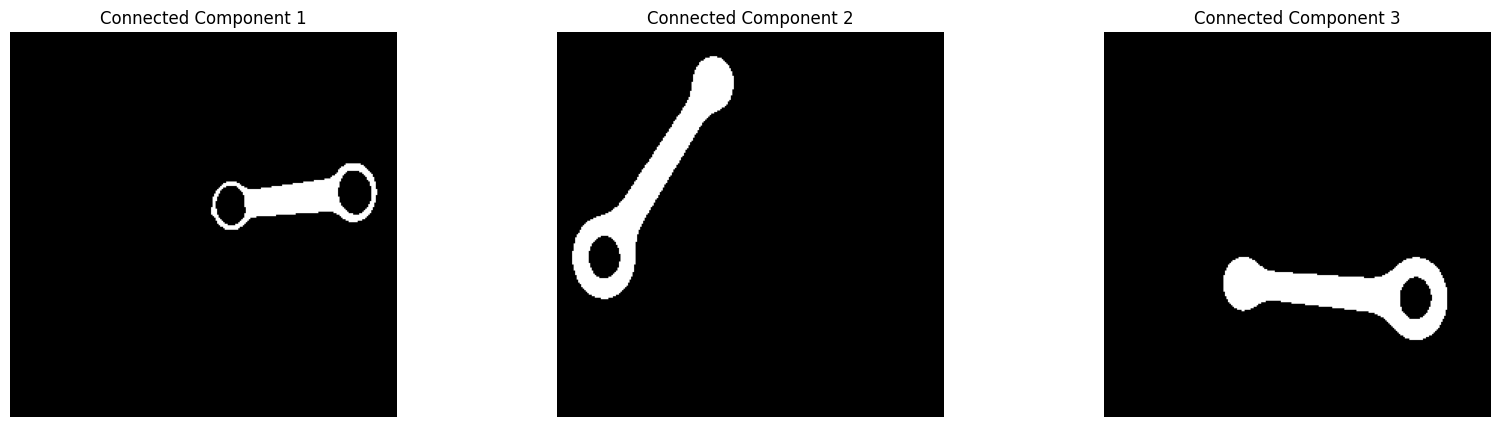

In [416]:
T_area = 50

objects = []

for idx, l in enumerate(labels):
    if np.sum(labeled_img == l) > T_area:
        obj = ((labeled_img == l)*255).astype('uint8')
        obj_dilatated = cv2.dilate(obj, square_k, iterations = 2)
        obj = cv2.medianBlur(cv2.bitwise_and(obj_dilatated, img_bin_denoised), 3)
        objects.append(obj)
        
plt.figure(figsize=(20,5))
for idx, comp in enumerate(objects):
    plt.subplot(1,len(objects), idx+1)
    plt.imshow(comp, cmap='gray')
    plt.title(f'Connected Component {idx+1}')
    plt.axis('off')  
plt.show()

Now, since could be present some object that isn't a rod and we don't want them, we remove it filtering through the presence or not of holes. To do this, we just call the *2 scan* method on the inverse of component image and doing so background become foreground. 

At this point, because rods hole contains portion of background, this region will be labeled, but with a different value respect BG. Inded, being included within a component, during the scan it recieved a differen label. So, to understood if an object contains an hole, you only need to check the number of the labels after than scan, excluding the first (BG), and it will be greater than 0. 

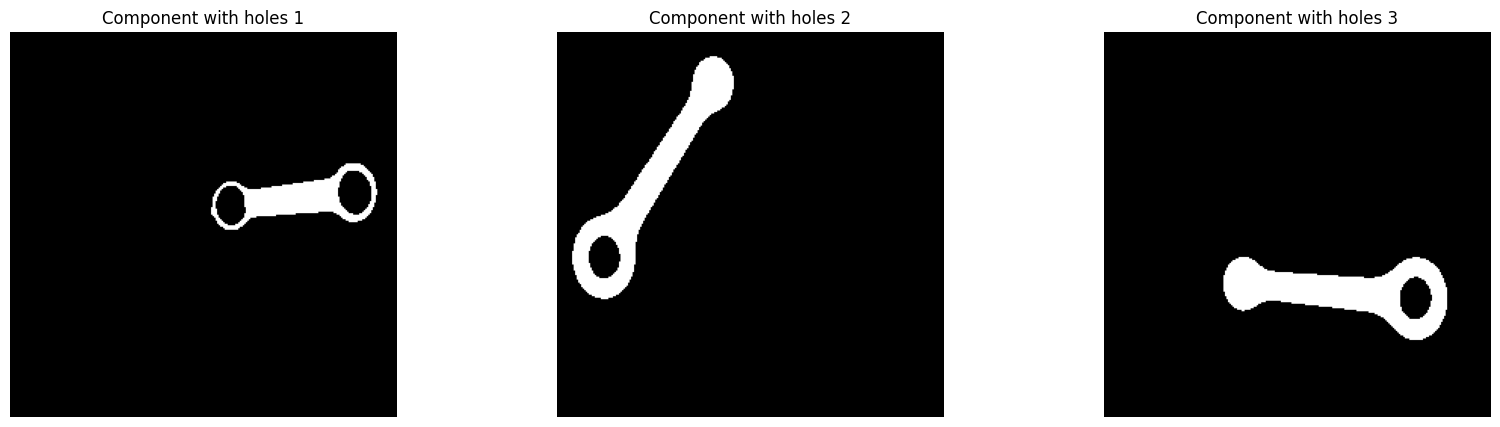

In [417]:
obj_with_holes = []

for idx, obj in enumerate(objects):
    tmp = _2_scan_algorithm(255-obj)
    
    if len(np.unique(tmp)[1:]) > 0:
        obj_with_holes.append(obj)
 
plt.figure(figsize=(20,5))
for idx, obj in enumerate(obj_with_holes):
    plt.subplot(1,len(obj_with_holes), idx+1)
    plt.imshow(obj, cmap='gray')
    plt.title(f'Component with holes {idx+1}')
    plt.axis('off')  
plt.show()

### Compute the pose of the object

The pose of an object is the combination of the object's position and orientation and to get it we have to evaluate its barycenter and moments. The barycenter is defined as the center of mass of the region R and to compute it we have to do the following operation:
$$
i_b = \frac{1}{A} \sum_{i \in R} i,\text{   } j_b = \frac{1}{A} \sum_{j \in R} j \text{   where A is the Area of the region}
$$
To speed up the computation, I've create 2 vector $v_i$, $v_j$ where each postion contains corresponding index value (e.g, $v_i = [0, 1,\dots, 255]$). So, with these two vector i compute the product with matrix representing the position where there is object, sum it up and divided it by the Area.

The central moments of the images is obtained by calculating the moments relative to the barycentre:
$$
M_{m,n}^{'} = \sum_{i,j \in R} (i - i_b)^m(j - j_b)^n
$$


In [418]:
def get_barycenter(img):
    A = np.sum(img==255)
    v_i = np.arange(0, img.shape[0])
    v_j = np.transpose(np.arange(0, img.shape[1]))
       
    i = (np.sum(np.dot(v_i, (img==255)))/A).astype('uint8')
    j = (np.sum(np.dot((img==255), v_j))/A).astype('uint8')
    
    return i, j

def get_central_moments(img):
    i_b, j_b = get_barycenter(img)
    
    moments = {}
    
    for m, n in [(0, 0), (1, 1), (2, 0), (0, 2)]:
        moment = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i,j] == 255:
                    moment += (i - i_b)**m * (j - j_b)**n
                
        moments[f"m{m}{n}"] = moment  
        
    return moments

# RETURNS: the coordinates to plot the lines with the function cv2.line()
def line(theta, centre, shape):
    i_start, i_end = 0, 0
    j_start, j_end = 0, 0
           
    
    if (theta*180/math.pi < 45) or (135 < theta*180/math.pi < 225) or (315 < theta*180/math.pi):
        i_start, i_end = 0, 0
        j_start, j_end = 0, 0
        for i in range(shape[0]):
            j = np.tan(theta)*(i-centre[0]) + centre[1]
            if 0 < j < shape[1]:
                if j_start == 0 and i_start == 0:
                    j_start = j.astype('uint8')
                    i_start = i

                j_end = j.astype('uint8')
                i_end = i 
    else:
        for j in range(shape[1]):
            i = (1/np.tan(theta))*(j-centre[1]) + centre[0]
            if 0 < i < shape[0]:
                if j_start == 0 and i_start == 0:
                    j_start = j
                    i_start = i.astype('uint8')

                j_end = j
                i_end = i.astype('uint8')
    
    return (j_start, i_start), (j_end, i_end)

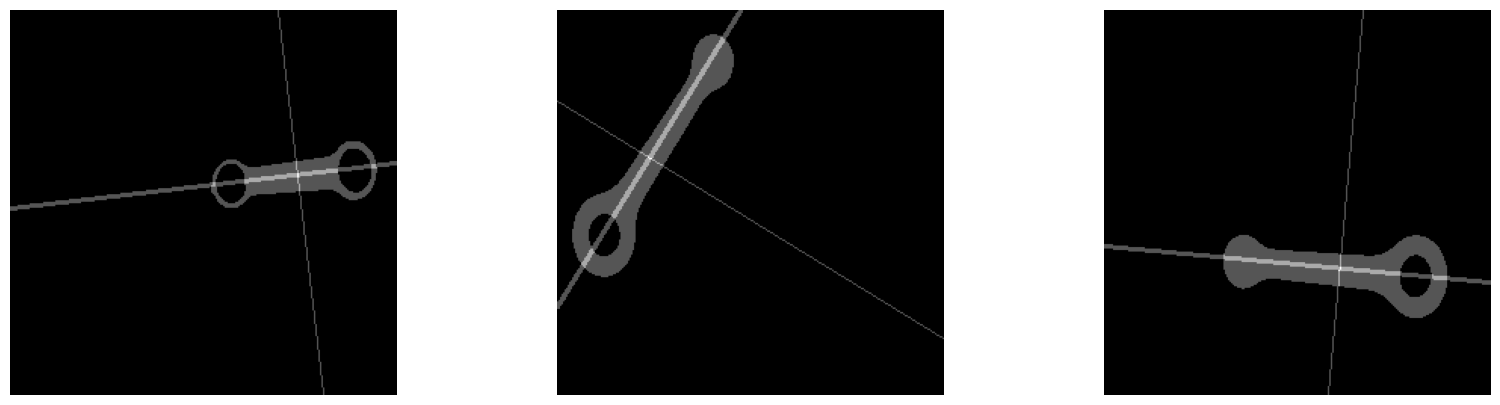

In [419]:
pose = []

plt.figure(figsize=(20,5)) 

for idx, obj in enumerate(obj_with_holes):
    
    # Area & Barycenter of the object
    moments = get_central_moments(obj)
    A = moments["m00"]
    i_b, j_b = get_barycenter(obj)
    
    # Evaluation of θ
    theta = -0.5 * np.arctan((2 * moments["m11"]) / (moments["m02"] - moments["m20"]))

    # Adjustment of theta (when M_02 > M_20 the axes are inverted...)
    if moments["m02"] > moments["m20"]:
        theta = theta + math.pi/2

    # draw majow axis
    startP, endP = line(theta, (i_b, j_b), obj.shape)
    major = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=2)
    
    # draw minor axis
    startP, endP = line(theta+math.pi/2, (i_b, j_b), obj.shape)
    minor = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=1)
    
    pose.append((theta, (i_b, j_b), major, minor))
    
    plt.subplot(1, len(obj_with_holes), idx+1)
    plt.imshow(major+minor+obj, cmap="gray")
    plt.axis('off')

plt.show()

### Compute MER and barycenter width
The Minimum Enclosing Rectangle is a a bounding box aligned to the object direction that touches the object contained in 4 points $C_1, C_2, C_3, C_4$ which they are laying at maximum distance on opposite sides of the two axes. To obtained it we search over the external contour points of the object comparing the distances of the points from major and minor axis. We can also compute vertices $V_1, V_2, V_3, V_4$ of the rectangle and now we can draw it using opencv function to plot lines. 

For the barycenter width we do almost the same thing and, always looking the contour points, we compare the distance of a point from the major axis with the minimum ever encounter and in base of the distance of it from the minor axis we choose the corresponding side. At the end we found 2 contour point lying on the minor axis $W_{b1}$, $W_{b2}$ and using euclidean distance we obtain the barycenter width.

The length and the widdrh of the object can be otained through the euclidean distance from 2 opposite vertices (that lying on the same side) of the MER.

Now after obtained length and width we can compute the elongation of the object. Since, could be still present some object that aren't a rod (just because they have a hole so the previus step not pruned it), we could now filter it deciding a threshold for elongation. Indeed, cicle object have an elongation nearly equal to 1, so 1.8 is fine as threshold. 

In [420]:
def find_mer_and_bar_width(comp, theta, B):
    alpha = -math.sin(theta)
    beta = math.cos(theta)

    # major axis
    a = alpha
    b = -beta
    c = beta * B[0] - alpha * B[1]
    
    # minor axis
    a_p = beta
    b_p = alpha
    c_p = - beta * B[1] - alpha * B[0]
    
    # Points at barycenter width
    min_wb_1, min_wb_2 = 100000, 100000

    dMAmin, dMImin = 100000, 100000
    dMAmax, dMImax = -100000, -100000
    normMA = math.sqrt(a ** 2 + b ** 2)
    normMI = math.sqrt(a_p ** 2 + b_p ** 2)

    contours, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for p in contours[0]:
        j = p[0][0]
        i = p[0][1]

        dMA = (a * j + b * i + c) / normMA
        dMI = (a_p * j + b_p * i + c_p) / normMI

        if dMA < dMAmin:
            c1 = (j, i)
            dMAmin = dMA

        if dMA > dMAmax:
            c2 = (j, i)
            dMAmax = dMA

        if dMI < dMImin:
            c3 = (j, i)
            dMImin = dMI

        if dMI > dMImax:
            c4 = (j, i)
            dMImax = dMI
            
        if abs(dMA) < min_wb_1 and dMI >= 0:
            wb_1 = (j, i)
            min_wb_1 = abs(dMA)

        if abs(dMA) < min_wb_2 and dMI <= 0:
            wb_2 = (j, i)
            min_wb_2 = abs(dMA)

    # Calculate 'c' coefficients for lines of MER's sides
    cl_1 = -(a * c1[0] + b * c1[1])
    cl_2 = -(a * c2[0] + b * c2[1])
    cw_1 = -(a_p * c3[0] + b_p * c3[1])
    cw_2 = -(a_p * c4[0] + b_p * c4[1])
    
    den = (a * b_p - b * a_p)

    # Calculate MER vertices
    v1 = ((b * cw_1 - b_p * cl_1) / den,
          (a_p * cl_1 - a * cw_1) / den)
    
    v2 = ((b * cw_2 - b_p * cl_1) / den,
          (a_p * cl_1 - a * cw_2) / den)
    
    v3 = ((b * cw_1 - b_p * cl_2) / den,
          (a_p * cl_2 - a * cw_1) / den)
    
    v4 = ((b * cw_2 - b_p * cl_2) / den,
          (a_p * cl_2 - a * cw_2) / den)

    return v1, v2, v3, v4, wb_1, wb_2

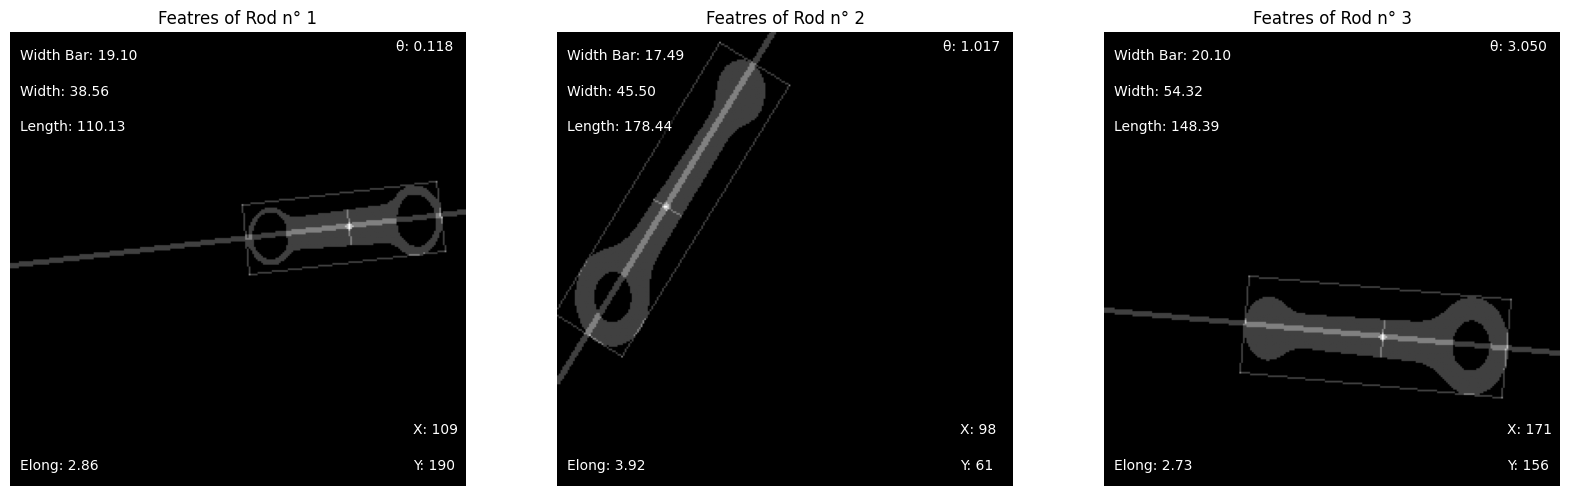

In [421]:
rods = []
rods_info = []

plt.figure(figsize=(20,10))
for idx, obj in enumerate(obj_with_holes):
    theta = pose[idx][0]
    i_b, j_b = pose[idx][1]
    
    v1, v2, v3, v4, wb_1, wb_2 = find_mer_and_bar_width(obj, theta,(i_b, j_b))
    
    length = dist.euclidean(v1, v3)
    width = dist.euclidean(v1, v2)
    bar_width = dist.euclidean(wb_1, wb_2)

    if length / width < 1.8:
        continue
    
    major, minor = pose[idx][2:]

    # draw barycenter
    bar = cv2.circle(np.zeros(obj.shape), (j_b, i_b), 2, (255, 255, 255), -1)
    
    # draw mer
    l1 = cv2.line(np.zeros(obj.shape), (int(v1[0]), int(v1[1])), (int(v3[0]), int(v3[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l2 = cv2.line(np.zeros(obj.shape), (int(v2[0]), int(v2[1])), (int(v1[0]), int(v1[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l3 = cv2.line(np.zeros(obj.shape), (int(v3[0]), int(v3[1])), (int(v4[0]), int(v4[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l4 = cv2.line(np.zeros(obj.shape), (int(v4[0]), int(v4[1])), (int(v2[0]), int(v2[1])), (255, 255, 255), 1, cv2.LINE_AA)
    
    #draw bar_width
    bar_width_line = cv2.line(np.zeros(obj.shape), (wb_1[0], wb_1[1]), (wb_2[0], wb_2[1]), (255, 255, 255), 1, cv2.LINE_AA)       
    
    rods.append(obj)
    rods_info.append(((l1, l2, l3, l4), length, width, bar_width, pose[idx]))
    
    plt.subplot(1, max(len(rods), 3), idx+1)
    plt.imshow(obj+l1+l2+l3+l4+bar+major+bar_width_line, cmap='gray')
    plt.title(f"Featres of Rod n° {idx+1}")
    plt.text(5,15, f"Width Bar: {bar_width:.2f}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(5,35, f"Width: {width:.2f}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(5,55, f"Length: {length:.2f}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(5,obj.shape[0]-10, f"Elong: {length/width:.2f}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(obj.shape[1]-30,obj.shape[0]-30, f"X: {i_b}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(obj.shape[1]-30,obj.shape[0]-10, f"Y: {j_b}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.text(obj.shape[1]-40,10, f"θ: {(math.pi/2+theta)%math.pi:.3f}", c="white",  bbox=dict(facecolor='black', alpha=0.4, edgecolor='black'))
    plt.axis('off')
    
plt.show()

### Holes analyses
Let's now identify number of holes present in all rods and inspect it to find position and the diameter of each rod holes. 

In [422]:
rod_type = []
holes_obj = []

for idx, obj in enumerate(rods):
    
    (l1, l2, l3, l4), length, width, bar_width, other_params = rods_info[idx]
    theta, (i_b, j_b) = other_params[:2]
    
    obj_holes = _2_scan_algorithm(255-obj)
    holes_labels = np.unique(obj_holes)
    n_holes = len(holes_labels)-1  # -1 is needed to remove the background 
    
    if n_holes == 1:
        rod_type.append('A') 
    elif n_holes == 2:
        rod_type.append('B')
    else:
        rod_type.append('Error!')
        
    hole_params = []
    
    for label in holes_labels:
        h = ((obj_holes == label) * 255).astype('uint8')
        
        # Only for labels that don't represent the background
        if np.sum(h == 255) < h.size//5:            
            moments_h = get_central_moments(h)
            A = moments_h["m00"]
            d = 2*np.sqrt(A/(2*math.pi))
            B = get_barycenter(h)

            hole_params.append((B, d))
    
    holes_obj.append(hole_params)

### Final Report
Here the final report of the project which summarize all what we have discover during inspection.

In [423]:
for idx in range(len(rods)):
    print("\033[1m" + f"Rod {idx+1} - Type {rod_type[idx]}\n" + "\033[0m")
    print(f"Position -> X : {rods_info[idx][4][1][1]}, Y: {rods_info[idx][4][1][0]}")
    print(f"Angle    -> θ : {math.pi/2+rods_info[idx][4][0]:.3f}")
    print(f"Length   -> L : {rods_info[idx][1]:.2f}")
    print(f"Width    -> W : {rods_info[idx][2]:.2f}")
    print(f"Width B. -> Wb: {rods_info[idx][3]:.2f}")
    for h, hole in enumerate(holes_obj[idx]):
        print(f"Hole {h+1}:")
        print(f"\tPosition -> X: {hole[0][1]}, Y: {hole[0][0]}")
        print(f"\tDiameter -> d: {hole[1]:.2f}")
    print("="*50)

Rod 1 - Type B

Position -> X : 190, Y: 109
Angle    -> θ : 3.260
Length   -> L : 110.13
Width    -> W : 38.56
Width B. -> Wb: 19.10
Hole 1:
	Position -> X: 227, Y: 105
	Diameter -> d: 17.84
Hole 2:
	Position -> X: 145, Y: 114
	Diameter -> d: 16.02
Rod 2 - Type A

Position -> X : 61, Y: 98
Angle    -> θ : 1.017
Length   -> L : 178.44
Width    -> W : 45.50
Width B. -> Wb: 17.49
Hole 1:
	Position -> X: 30, Y: 148
	Diameter -> d: 17.02
Rod 3 - Type A

Position -> X : 156, Y: 171
Angle    -> θ : 3.050
Length   -> L : 148.39
Width    -> W : 54.32
Width B. -> Wb: 20.10
Hole 1:
	Position -> X: 205, Y: 175
	Diameter -> d: 17.02
